In [27]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import time
import os

In [28]:
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale=1.0):
        super(FourierFeatures, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.B = nn.Parameter(scale * torch.randn(in_features, out_features), requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return torch.cat([x, fourier], dim=-1) 

In [29]:
class Network(nn.Module):
    def __init__(self, num_input=2, fourier_features=10, layers=[128, 128, 128, 128], num_output=3, scale=1.0):
        super(Network, self).__init__()
        self.fourier = FourierFeatures(num_input, fourier_features, scale)
        input_size = num_input + 2*fourier_features
        self.input_layer = nn.Linear(input_size, layers[0])
        self.hidden_layer = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layer.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], num_output)

    def forward(self, x):
        x = self.fourier(x)
        out = torch.tanh(self.input_layer(x))
        for layer in self.hidden_layer:
            out = torch.tanh(layer(out))
        out = self.output_layer(out)
        return out

In [46]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)
        print("CUDA Available:", torch.cuda.is_available())

        # Problem parameters
        self.Re = 800.0
        self.L = 10.0
        self.H = 1.0
        self.step_height = 0.0
        self.step_length = 2.0

        # Domain discretization
        self.nx = 350
        self.ny = 35

        # Create computational domain
        self.create_domain()

        # Loss criterion
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        # , lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=1.0,
            max_iter = 1000,
            max_eval = 1000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        # Loss tracking
        self.loss_history = []

    def create_domain(self):
        # Create full grid with corrected y domain
        self.x = torch.linspace(0, self.L, self.nx, device=self.device)
        self.y = torch.linspace(-0.5, 0.5, self.ny, device=self.device)
        X, Y = torch.meshgrid(self.x, self.y, indexing='ij')

        # Create 2D tensor for all points
        self.XY = torch.stack([X.T, Y.T], dim=-1)

        # Create masks for different regions
        self.inlet_mask = (self.XY[:, :, 0] < 1e-6) & (self.XY[:, :, 1] > 1e-6)
        # Step wall is at x=0 and y <= 0 (lower half)
        self.step_wall_mask = (self.XY[:, :, 0] < 1e-6) & (self.XY[:, :, 1] <= 1e-6)
        # Outlet
        self.outlet_mask = self.XY[:, :, 0] > self.L - 1e-6
        # Bottom and top walls
        self.bottom_wall_mask = (self.XY[:, :, 1] < -0.5 + 1e-6) & (self.XY[:, :, 0] >= 1e-6) & (~self.outlet_mask)
        self.top_wall_mask = (self.XY[:, :, 1] > 0.5 - 1e-6) & (self.XY[:, :, 0] >= 1e-6) & (~self.outlet_mask)
        # Interior points
        self.interior_mask = (~self.inlet_mask) & (~self.step_wall_mask) & (~self.outlet_mask) & (~self.bottom_wall_mask) & (~self.top_wall_mask)

        # Create boundary condition values
        y_inlet = self.XY[self.inlet_mask][:, 1]
        self.u_inlet_values = 24 * y_inlet * (0.5 - y_inlet)
        self.v_inlet_values = torch.zeros_like(y_inlet)

        # Store grid shape for visualization
        self.grid_shape = (self.ny, self.nx)

        # Grid spacing for FD
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]

    def apply_hard_boundary_conditions(self, uvp):
        u = uvp[:, :, 0]
        v = uvp[:, :, 1]
        p = uvp[:, :, 2]

        # Inlet BC - parabolic profile
        u[self.inlet_mask] = self.u_inlet_values
        v[self.inlet_mask] = self.v_inlet_values

        # Step wall BC
        u[self.step_wall_mask] = 0.0
        v[self.step_wall_mask] = 0.0

        # Wall BC - no-slip
        u[self.bottom_wall_mask] = 0.0
        v[self.bottom_wall_mask] = 0.0
        u[self.top_wall_mask] = 0.0
        v[self.top_wall_mask] = 0.0

        return torch.stack([u, v, p], dim=-1)

    def compute_derivatives_fd(self, uvp):
        u = uvp[:, :, 0]
        v = uvp[:, :, 1]
        p = uvp[:, :, 2]

        # Initialize derivative tensors
        u_x = torch.zeros_like(u)
        u_y = torch.zeros_like(u)
        v_x = torch.zeros_like(v)
        v_y = torch.zeros_like(v)
        p_x = torch.zeros_like(p)
        p_y = torch.zeros_like(p)
        u_xx = torch.zeros_like(u)
        u_yy = torch.zeros_like(u)
        v_xx = torch.zeros_like(v)
        v_yy = torch.zeros_like(v)

        # Central differences for first derivatives
        u_x[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * self.dx)
        v_x[:, 1:-1] = (v[:, 2:] - v[:, :-2]) / (2 * self.dx)
        p_x[:, 1:-1] = (p[:, 2:] - p[:, :-2]) / (2 * self.dx)
        u_y[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2 * self.dy)
        v_y[1:-1, :] = (v[2:, :] - v[:-2, :]) / (2 * self.dy)
        p_y[1:-1, :] = (p[2:, :] - p[:-2, :]) / (2 * self.dy)

        # Second derivatives
        u_xx[:, 1:-1] = (u[:, 2:] - 2*u[:, 1:-1] + u[:, :-2]) / (self.dx**2)
        v_xx[:, 1:-1] = (v[:, 2:] - 2*v[:, 1:-1] + v[:, :-2]) / (self.dx**2)
        u_yy[1:-1, :] = (u[2:, :] - 2*u[1:-1, :] + u[:-2, :]) / (self.dy**2)
        v_yy[1:-1, :] = (v[2:, :] - 2*v[1:-1, :] + v[:-2, :]) / (self.dy**2)

        return u, v, p, u_x, u_y, v_x, v_y, p_x, p_y, u_xx, u_yy, v_xx, v_yy

    def loss_f(self):
        self.optimizer.zero_grad()

        # predict on entire domain
        xy_flat = self.XY.reshape(-1, 2)
        self.uvp_flat = self.network(xy_flat)
        uvp = self.uvp_flat.reshape(self.ny, self.nx, 3)

        # Apply hard boundary conditions
        uvp = self.apply_hard_boundary_conditions(uvp)

        # Compute derivatives
        u, v, p, u_x, u_y, v_x, v_y, p_x, p_y, u_xx, u_yy, v_xx, v_yy = self.compute_derivatives_fd(uvp)

        # Extract interior points
        u_int = u[self.interior_mask]
        v_int = v[self.interior_mask]
        u_x_int = u_x[self.interior_mask]
        u_y_int = u_y[self.interior_mask]
        v_x_int = v_x[self.interior_mask]
        v_y_int = v_y[self.interior_mask]
        p_x_int = p_x[self.interior_mask]
        p_y_int = p_y[self.interior_mask]
        u_xx_int = u_xx[self.interior_mask]
        u_yy_int = u_yy[self.interior_mask]
        v_xx_int = v_xx[self.interior_mask]
        v_yy_int = v_yy[self.interior_mask]

        # Navier-Stokes equations residuals
        continuity = u_x_int + v_y_int
        momentum_x = u_int * u_x_int + v_int * u_y_int + p_x_int - (1/self.Re) * (u_xx_int + u_yy_int)
        momentum_y = u_int * v_x_int + v_int * v_y_int + p_y_int - (1/self.Re) * (v_xx_int + v_yy_int)

        # Only PDE loss (no BC loss since we use hard BC)
        self.loss = self.criterion(continuity, torch.zeros_like(continuity)) + \
                    self.criterion(momentum_x, torch.zeros_like(momentum_x)) + \
                    self.criterion(momentum_y, torch.zeros_like(momentum_y))

        self.loss.backward()
        return self.loss

    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            self.loss_history.append(loss.item())
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.8f}")
            if i % 100 == 0:
                torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Backward-facing step/Ra=800/2-FF-FD-PINNs/model')
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
        torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Backward-facing step/Ra=800/2-FF-FD-PINNs/model')
        
    def plot(self):
        self.network.eval()
        with torch.no_grad():
            xy_flat = self.XY.reshape(-1, 2)
            uvp_flat = self.network(xy_flat)
            uvp = uvp_flat.reshape(self.ny, self.nx, 3)   
    
            u_all = uvp[:, :, 0].cpu().numpy()
            v_all = uvp[:, :, 1].cpu().numpy()
            p_all = uvp[:, :, 2].cpu().numpy()
    
        x = self.XY[:, :, 0].cpu().numpy()
        y = self.XY[:, :, 1].cpu().numpy()
        
        #setup
        save_dir = "C:/Users/hossein/Result/Backward-facing step/Ra=800/2-FF-FD-PINNs"
        plt.rcParams.update({
            "font.family": "Times New Roman",
            "font.style": "italic"
        })
    
        # 1. u-velocity
        plt.figure(figsize=(12, 3))
        ax = plt.gca()
        cu = ax.contourf(x, y, u_all, levels=50, cmap='jet')
        cbar_u = plt.colorbar(cu, orientation='horizontal', pad=0.2, aspect=60, location='top')
        cbar_u.ax.set_title('u-velocity', fontsize=14, pad=10)
        cbar_u.ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('x', fontsize=14)
        ax.set_ylabel('y', fontsize=14)
        ax.axvline(x=0, ymin=0, ymax=0.5, color='k', linewidth=3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "u_velocity.png"), dpi=300)
        plt.show()
        plt.close()
    
        # 2. v-velocity
        plt.figure(figsize=(12, 3))
        ax = plt.gca()
        cv = ax.contourf(x, y, v_all, levels=50, cmap='jet')
        cbar_v = plt.colorbar(cv, orientation='horizontal', pad=0.2, aspect=60, location='top')
        cbar_v.ax.set_title('v-velocity', fontsize=14, pad=10)
        cbar_v.ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('x', fontsize=14)
        ax.set_ylabel('y', fontsize=14)
        ax.axvline(x=0, ymin=0, ymax=0.5, color='k', linewidth=3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "v_velocity.png"), dpi=300)
        plt.show()
        plt.close()
    
        # 3. Pressure
        plt.figure(figsize=(12, 3))
        ax = plt.gca()
        cp = ax.contourf(x, y, p_all, levels=50, cmap='jet')
        cbar_p = plt.colorbar(cp, orientation='horizontal', pad=0.2, aspect=60, location='top')
        cbar_p.ax.set_title('Pressure', fontsize=14, pad=10)
        cbar_p.ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('x', fontsize=14)
        ax.set_ylabel('y', fontsize=14)
        ax.axvline(x=0, ymin=0, ymax=0.5, color='k', linewidth=3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "pressure.png"), dpi=300)
        plt.show()
        plt.close()

        # 4. streamline
        plt.figure(figsize=(12, 2.4))
        ax = plt.gca()
        x = np.linspace(0, self.L, self.nx)
        y = np.linspace(-0.5, 0.5, self.ny)
        X, Y = np.meshgrid(x, y)
        ax.streamplot(X, Y, u_all, v_all, color='red', cmap='autumn', linewidth=0.5, density=2, arrowsize=0.6)
        ax.set_xlabel("x", fontsize=14)
        ax.set_ylabel("y", fontsize=14)
        ax.set_title("Streamline", fontsize=14)
        ax.set_ylim(-0.5, 0.5)
        ax.set_xlim(0, self.L)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "streamline.png"), dpi=300)
        plt.show()
        plt.close()

    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Function History')
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()
        df = pd.DataFrame({"loss": self.loss_history})
        df.to_csv("C:/Users/hossein/Result/Backward-facing step/Ra=800/2-FF-FD-PINNs/loss_history3.csv", index=False)

CUDA Available: True
Iteration 0, Loss: 0.00000009
Iteration 10, Loss: 0.00001330
Iteration 20, Loss: 0.00000349
Iteration 30, Loss: 0.00000095
Iteration 40, Loss: 0.00000049
Iteration 50, Loss: 0.00000025
Iteration 60, Loss: 0.00000016
Iteration 70, Loss: 0.00000012
Iteration 80, Loss: 0.00000010
Iteration 90, Loss: 0.00000010
Iteration 100, Loss: 0.00000010
Iteration 110, Loss: 0.00000010
Iteration 120, Loss: 0.00000009
Iteration 130, Loss: 0.00000009
Iteration 140, Loss: 0.00000009
Iteration 150, Loss: 0.00000009
Iteration 160, Loss: 0.00000009
Iteration 170, Loss: 0.00000009
Iteration 180, Loss: 0.00000009
Iteration 190, Loss: 0.00000009
Iteration 200, Loss: 0.00000009
Iteration 210, Loss: 0.00000014
Iteration 220, Loss: 0.00000009
Iteration 230, Loss: 0.00000009
Iteration 240, Loss: 0.00000009
Iteration 250, Loss: 0.00000009
Iteration 260, Loss: 0.00000009
Iteration 270, Loss: 0.00000009
Iteration 280, Loss: 0.00000009
Iteration 290, Loss: 0.00000009
Iteration 300, Loss: 0.0000000

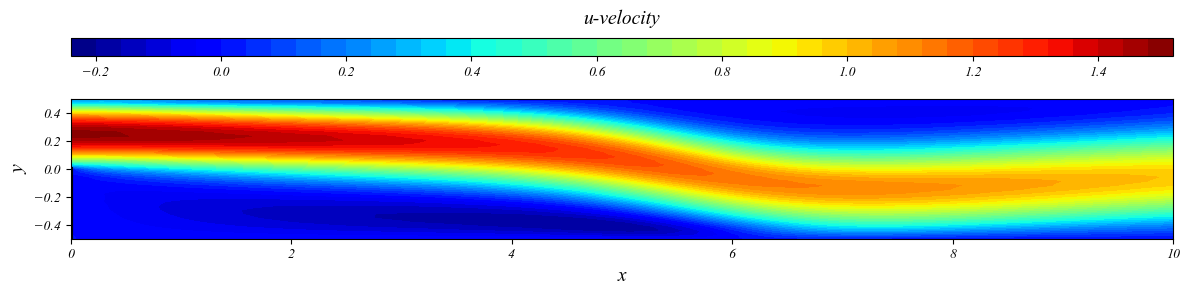

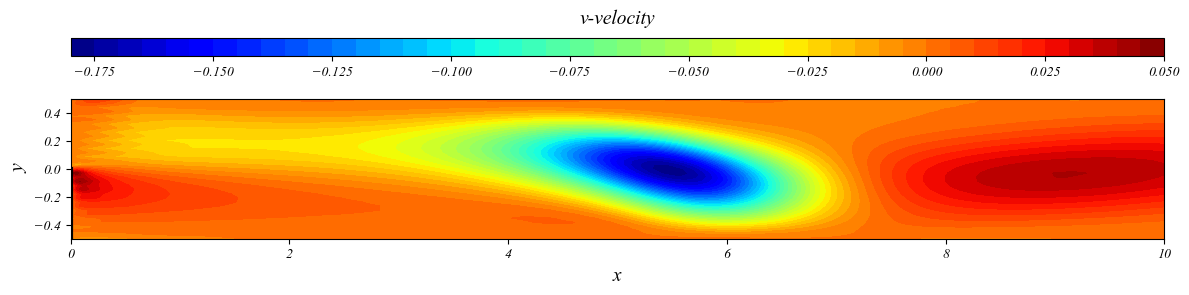

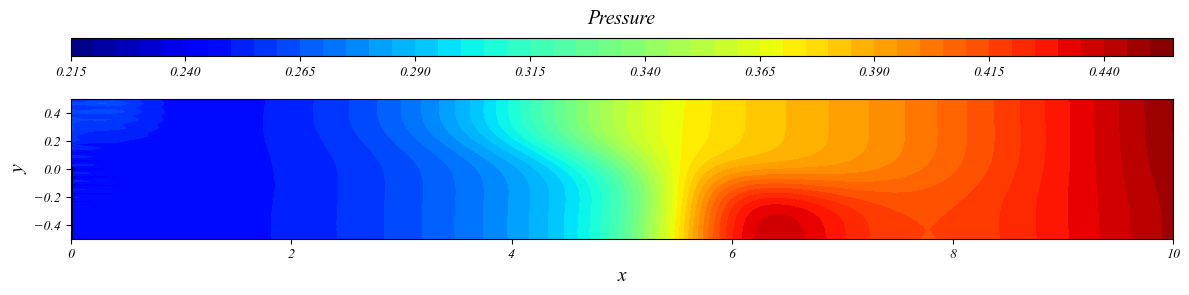

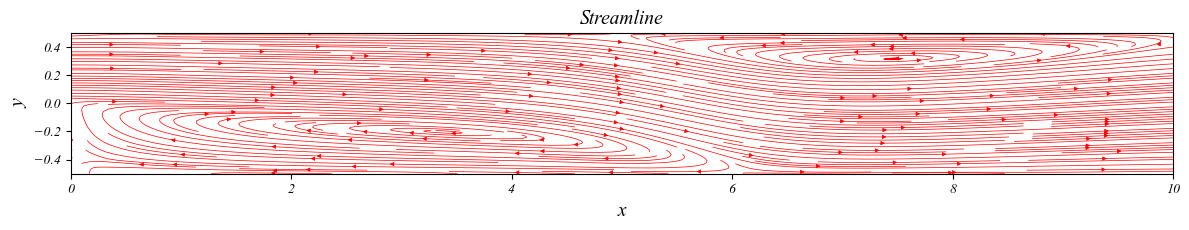

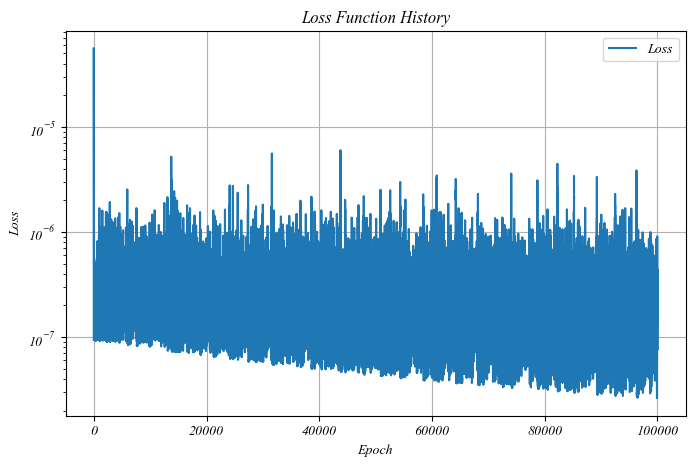

In [47]:
net = Pinns()
net.network.load_state_dict(torch.load(r'C:/Users/hossein/Result/Backward-facing step/Ra=800/2-FF-FD-PINNs/model'))
net.train(num_epochs=100000)
net.plot()
net.plot_loss()